Hi Everyone! This is my very first post and exploration of using machine learning algorithms to see if we can predict the ratings for apps on the google play store. Most of the posts are exploration data analysis and I  hope to contribute a little via the use of machine learning!

I've been studying about machine learning and am still a beginner, so if there's any comments/suggestions please feel free to tell me and I hope we can all learn together!

Naturally we start by importing the common libraries at the start

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
df = pd.read_csv('./googleplaystore.csv')

Checking out the info, there's a not of null values that need to be addressed. Since my main objective is predicting the ratings of the apps, I deleted all the NaN values, just for simplicity sake.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
App               10841 non-null object
Category          10841 non-null object
Rating            9367 non-null float64
Reviews           10841 non-null object
Size              10841 non-null object
Installs          10841 non-null object
Type              10840 non-null object
Price             10841 non-null object
Content Rating    10840 non-null object
Genres            10841 non-null object
Last Updated      10841 non-null object
Current Ver       10833 non-null object
Android Ver       10838 non-null object
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [6]:
df.dropna(inplace = True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9360 entries, 0 to 10840
Data columns (total 13 columns):
App               9360 non-null object
Category          9360 non-null object
Rating            9360 non-null float64
Reviews           9360 non-null object
Size              9360 non-null object
Installs          9360 non-null object
Type              9360 non-null object
Price             9360 non-null object
Content Rating    9360 non-null object
Genres            9360 non-null object
Last Updated      9360 non-null object
Current Ver       9360 non-null object
Android Ver       9360 non-null object
dtypes: float64(1), object(12)
memory usage: 1023.8+ KB


For the following steps, in order to process the data in the machine learning algorithms, we need to first convert it from text to numbers, as from what i understand, most algorithms run better that way. From most of the books I've read, data cleaning/preprocessing is **THE** most important part of any machine learning process, as high quality data translates to high quality predictions and models.

In [8]:
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


From the categorical column, I converted each category into an individual number. In the later sections when we do apply machine learning, two methods will be applied to the code, being integer encoding(which we are doing now) and one-hot encoding, aka dummy variables.  

The main reason as to why I understand we do this transformation is mainly because integer encoding relies on the fact that there's a relationship between each category(e.g. think age range vs types of animals). In this case however, it's hard to really determine such a relationship, hence dummy/one-hot encoding might help provide better predictive accuracy. 

In [9]:
# Cleaning Categories into integers
CategoryString = df["Category"]
categoryVal = df["Category"].unique()
categoryValCount = len(categoryVal)
category_dict = {}
for i in range(0,categoryValCount):
    category_dict[categoryVal[i]] = i
df["Category_c"] = df["Category"].map(category_dict).astype(int)

Cleaning of sizes of the apps and also filling up the missing values using ffill

In [10]:
#scaling and cleaning size of installation
def change_size(size):
    if 'M' in size:
        x = size[:-1]
        x = float(x)*1000000
        return(x)
    elif 'k' == size[-1:]:
        x = size[:-1]
        x = float(x)*1000
        return(x)
    else:
        return None

df["Size"] = df["Size"].map(change_size)

#filling Size which had NA
df.Size.fillna(method = 'ffill', inplace = True)


Cleaning the number of installations column

In [11]:
#Cleaning no of installs classification
df['Installs'] = [int(i[:-1].replace(',','')) for i in df['Installs']]

Converting the paid/free classification types into binary

In [12]:
#Converting Type classification into binary
def type_cat(types):
    if types == 'Free':
        return 0
    else:
        return 1

df['Type'] = df['Type'].map(type_cat)

Converting of the content rating section into integers. In this specific instance, given that the concent rating is somewhat relatable and has an order to it, we do not use one-hot encoding.

In [13]:
#Cleaning of content rating classification
RatingL = df['Content Rating'].unique()
RatingDict = {}
for i in range(len(RatingL)):
    RatingDict[RatingL[i]] = i
df['Content Rating'] = df['Content Rating'].map(RatingDict).astype(int)

I dropped these portions of information as i deemed it unecessary for our machine learning algorithm

In [14]:
#dropping of unrelated and unnecessary items
df.drop(labels = ['Last Updated','Current Ver','Android Ver','App'], axis = 1, inplace = True)

Technically when doing the cleaning of genres, one-hot should also be applied in this instance. However, I did not as firstly, it's a subset of the categorical column and secondly, application of a dummy variable would significantly increase the number of independent variables. 

So to combat this instead, we ran two seperate regressions, one including and one excluding such genre data. When including the data, we only considered in the impact/information provided via the genre section purely based on it's numeric value.

In [15]:
#Cleaning of genres
GenresL = df.Genres.unique()
GenresDict = {}
for i in range(len(GenresL)):
    GenresDict[GenresL[i]] = i
df['Genres_c'] = df['Genres'].map(GenresDict).astype(int)

Cleaning of the prices of the apps to floats

In [16]:
#Cleaning prices
def price_clean(price):
    if price == '0':
        return 0
    else:
        price = price[1:]
        price = float(price)
        return price

df['Price'] = df['Price'].map(price_clean).astype(float)

Finally converting the number reviews column into integers

In [17]:
# convert reviews to numeric
df['Reviews'] = df['Reviews'].astype(int)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9360 entries, 0 to 10840
Data columns (total 11 columns):
Category          9360 non-null object
Rating            9360 non-null float64
Reviews           9360 non-null int32
Size              9360 non-null float64
Installs          9360 non-null int64
Type              9360 non-null int64
Price             9360 non-null float64
Content Rating    9360 non-null int32
Genres            9360 non-null object
Category_c        9360 non-null int32
Genres_c          9360 non-null int32
dtypes: float64(3), int32(4), int64(2), object(2)
memory usage: 731.2+ KB


Doing checks and we are good to go! So I created first this dataframe that has **integer encoding** of categorical variables, defined as df

In [19]:
df.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Category_c,Genres_c
0,ART_AND_DESIGN,4.1,159,19000000.0,10000,0,0.0,0,Art & Design,0,0
1,ART_AND_DESIGN,3.9,967,14000000.0,500000,0,0.0,0,Art & Design;Pretend Play,0,1
2,ART_AND_DESIGN,4.7,87510,8700000.0,5000000,0,0.0,0,Art & Design,0,0
3,ART_AND_DESIGN,4.5,215644,25000000.0,50000000,0,0.0,1,Art & Design,0,0
4,ART_AND_DESIGN,4.3,967,2800000.0,100000,0,0.0,0,Art & Design;Creativity,0,2


In this instance, I created another dataframe that specifically created **dummy values** for each categorical instance in the dataframe, defined as df2

In [20]:
# for dummy variable encoding for Categories
df2 = pd.get_dummies(df, columns=['Category'])

In [21]:
df2.head()

,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Category_c,Genres_c,...,Category_PERSONALIZATION,Category_PHOTOGRAPHY,Category_PRODUCTIVITY,Category_SHOPPING,Category_SOCIAL,Category_SPORTS,Category_TOOLS,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER
0,4.1,159,19000000.0,10000,0,0.0,0,Art & Design,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.9,967,14000000.0,500000,0,0.0,0,Art & Design;Pretend Play,0,1,...,0,0,0,0,0,0,0,0,0,0
2,4.7,87510,8700000.0,5000000,0,0.0,0,Art & Design,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.5,215644,25000000.0,50000000,0,0.0,1,Art & Design,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.3,967,2800000.0,100000,0,0.0,0,Art & Design;Creativity,0,2,...,0,0,0,0,0,0,0,0,0,0


After our final checks for the preprocessing of our data, looks like we can start work! So the next question is what exactly are we doing and how are we doing it.

So the goal of this instance is to see if we can use existing data provided(e.g. Size, no of reviews) to predict the ratings of the google applications. **In other words, our dependent variable Y, would be the rating of the apps.**  

One important factor to note is that the dependent variable Y, is a continuous variable(aka infinite no of combinations), as compared to a discrete variable. Naturally there are ways to convert our Y to a discrete variable but **I decided to keep Y as a continuous variable** for the purposes of this machine learning session. 

**Next question, what models should we apply and how should we evaluate them?**

Model wise, I'm not too sure as well as there are like a ton of models out there that can be used for machine learning. Hence, I basically just chose the 3 most common models that I use, being linear regression, SVR, and random forest regressor. 

**We technically run 4 regressions for each model used, as we consider one-hot vs interger encoded results for the category section, as well as including/excluding the genre section.**

We then evaluate the models by comparing the predicted results against the actual results graphically, as well as use the mean squared error, mean absolute error and mean squared log error as possible benchmarks.

The use of the error term will be evaluated right at the end after running through all the models.

In [22]:
# let's use 3 different regression models with two different techniques on treating the categorical variable

So before we start, the following is code to obtain the error terms for the various models, for comparability.

In [23]:
#for evaluation of error term and 
def Evaluationmatrix(y_true, y_predict):
    print ('Mean Squared Error: '+ str(metrics.mean_squared_error(y_true,y_predict)))
    print ('Mean absolute Error: '+ str(metrics.mean_absolute_error(y_true,y_predict)))
    print ('Mean squared Log Error: '+ str(metrics.mean_squared_log_error(y_true,y_predict)))

In [24]:
#to add into results_index for evaluation of error term 
def Evaluationmatrix_dict(y_true, y_predict, name = 'Linear - Integer'):
    dict_matrix = {}
    dict_matrix['Series Name'] = name
    dict_matrix['Mean Squared Error'] = metrics.mean_squared_error(y_true,y_predict)
    dict_matrix['Mean Absolute Error'] = metrics.mean_absolute_error(y_true,y_predict)
    dict_matrix['Mean Squared Log Error'] = metrics.mean_squared_log_error(y_true,y_predict)
    return dict_matrix

We start off by looking at **linear regression** model (without the genre label)

In [25]:
#excluding Genre label
from sklearn.linear_model import LinearRegression 

#Integer encoding
X = df.drop(labels = ['Category','Rating','Genres','Genres_c'],axis = 1)
y = df.Rating
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
model = LinearRegression()
model.fit(X_train,y_train)
Results = model.predict(X_test)

#Creation of results dataframe and addition of first entry
resultsdf = pd.DataFrame()
resultsdf = resultsdf.from_dict(Evaluationmatrix_dict(y_test,Results),orient = 'index')
resultsdf = resultsdf.transpose()

#dummy encoding

X_d = df2.drop(labels = ['Rating','Genres','Category_c','Genres_c'],axis = 1)
y_d = df2.Rating
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d, test_size=0.30)
model_d = LinearRegression()
model_d.fit(X_train_d,y_train_d)
Results_d = model_d.predict(X_test_d)

#adding results into results dataframe
resultsdf = resultsdf.append(Evaluationmatrix_dict(y_test_d,Results_d, name = 'Linear - Dummy'),ignore_index = True)

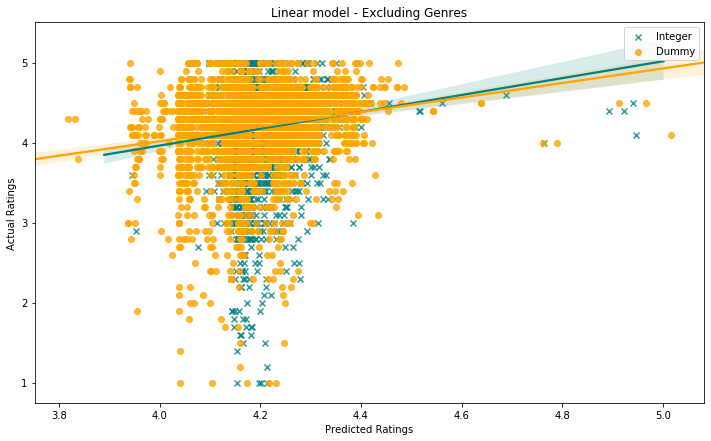

In [27]:
plt.figure(figsize=(12,7))
sns.regplot(Results,y_test,color='teal', label = 'Integer', marker = 'x')
sns.regplot(Results_d,y_test_d,color='orange',label = 'Dummy')
plt.legend()
plt.title('Linear model - Excluding Genres')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

In [28]:
print ('Actual mean of population:' + str(y.mean()))
print ('Integer encoding(mean) :' + str(Results.mean()))
print ('Dummy encoding(mean) :'+ str(Results_d.mean()))
print ('Integer encoding(std) :' + str(Results.std()))
print ('Dummy encoding(std) :'+ str(Results_d.std()))

Actual mean of population:4.191837606837612
Integer encoding(mean) :4.200488630602306
Dummy encoding(mean) :4.194098910763217
Integer encoding(std) :0.0600779306937269
Dummy encoding(std) :0.10379447669354569


At first glance, it's hard to really see which model(dummy vs one-hot) is better in terms of predictive accuracy. What is striking however is the that at first glance, the dummy model seems favors the outcome of a lower rating compared to the integer model. 

Although if we look at the actual mean of the predictive results, both are approximately the same, **however the dummy encoded results have a much larger standard deviation as compared to the integer encoded model.**

Next is looking at the linear model including the genre label as a numeric value.

In [29]:
#Including genre label

#Integer encoding
X = df.drop(labels = ['Category','Rating','Genres'],axis = 1)
y = df.Rating
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
model = LinearRegression()
model.fit(X_train,y_train)
Results = model.predict(X_test)

resultsdf = resultsdf.append(Evaluationmatrix_dict(y_test,Results, name = 'Linear(inc Genre) - Integer'),ignore_index = True)

#dummy encoding

X_d = df2.drop(labels = ['Rating','Genres','Category_c'],axis = 1)
y_d = df2.Rating
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d, test_size=0.30)
model_d = LinearRegression()
model_d.fit(X_train_d,y_train_d)
Results_d = model_d.predict(X_test_d)

resultsdf = resultsdf.append(Evaluationmatrix_dict(y_test_d,Results_d, name = 'Linear(inc Genre) - Dummy'),ignore_index = True)

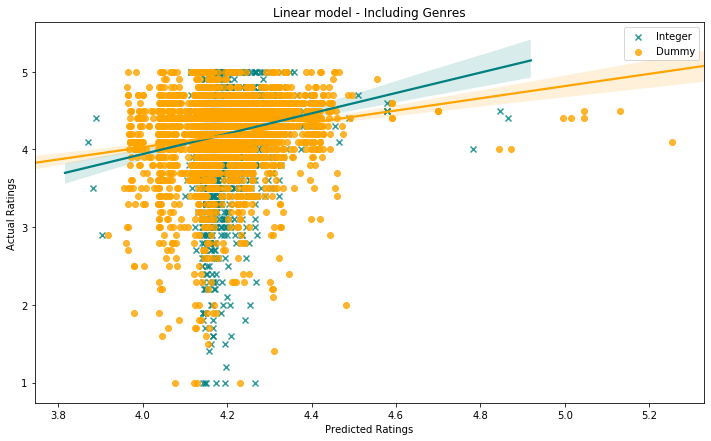

In [30]:
plt.figure(figsize=(12,7))
sns.regplot(Results,y_test,color='teal', label = 'Integer', marker = 'x')
sns.regplot(Results_d,y_test_d,color='orange',label = 'Dummy')
plt.legend()
plt.title('Linear model - Including Genres')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

In [31]:
print ('Integer encoding(mean) :' + str(Results.mean()))
print ('Dummy encoding(mean) :'+ str(Results_d.mean()))
print ('Integer encoding(std) :' + str(Results.std()))
print ('Dummy encoding(std) :'+ str(Results_d.std()))

Integer encoding(mean) :4.19321601698497
Dummy encoding(mean) :4.19929899061823
Integer encoding(std) :0.0550897443728876
Dummy encoding(std) :0.11390986341892519


When including the genre data, we see a slight difference in the mean between the integer and dummy encoded linear models. The dummy encoded model's std is still higher than the integer encoded model.

What's striking to me personally is that the dummy encoded regression line in the scatterplot is now flatter than the integer encoded regression line, which might suggest a "worse" outcome, given that usually you would want your regression's beta value to be closer to 1 than to 0. 

**Next up is the SVR model.**

In [32]:
#Excluding genres
from sklearn import svm
#Integer encoding

X = df.drop(labels = ['Category','Rating','Genres','Genres_c'],axis = 1)
y = df.Rating
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

model2 = svm.SVR()
model2.fit(X_train,y_train)

Results2 = model2.predict(X_test)

resultsdf = resultsdf.append(Evaluationmatrix_dict(y_test,Results2, name = 'SVM - Integer'),ignore_index = True)

#dummy based


X_d = df2.drop(labels = ['Rating','Genres','Category_c','Genres_c'],axis = 1)
y_d = df2.Rating

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d, test_size=0.30)

model2 = svm.SVR()
model2.fit(X_train_d,y_train_d)

Results2_d = model2.predict(X_test_d)

resultsdf = resultsdf.append(Evaluationmatrix_dict(y_test_d,Results2_d, name = 'SVM - Dummy'),ignore_index = True)

C:\Users\ruji-\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\ruji-\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


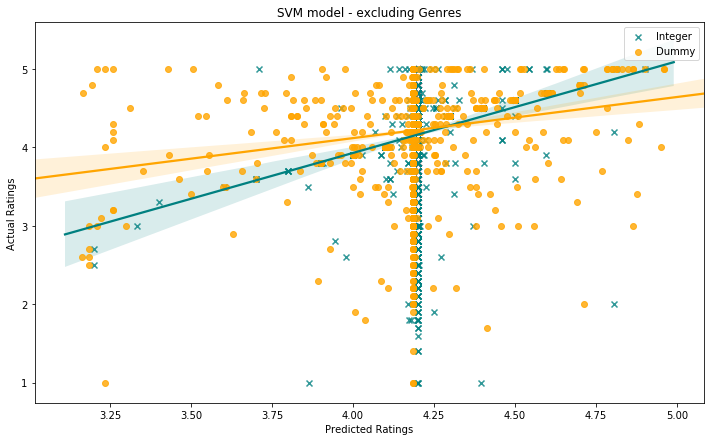

In [33]:
plt.figure(figsize=(12,7))
sns.regplot(Results2,y_test,color='teal', label = 'Integer', marker = 'x')
sns.regplot(Results2_d,y_test_d,color='orange',label = 'Dummy')
plt.legend()
plt.title('SVM model - excluding Genres')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

In [34]:
print ('Integer encoding(mean) :' + str(Results2.mean()))
print ('Dummy encoding(mean) :'+ str(Results2_d.mean()))
print ('Integer encoding(std) :' + str(Results2.std()))
print ('Dummy encoding(std) :'+ str(Results2_d.std()))

Integer encoding(mean) :4.203811739797131
Dummy encoding(mean) :4.186421797881493
Integer encoding(std) :0.06788167265009039
Dummy encoding(std) :0.13941518476377865


The results are quite interesting. Overall the model predicted quite a bit of ratings to be approximately at 4.2, even though the actual ratings were not. Looking at the scatterplot, the integer encoded model seems to have performed better in this instance.

As usual, the dummy encoded model has a higher std than the integer encoded model.

In [35]:
#Integer encoding, including Genres_c
model2a = svm.SVR()

X = df.drop(labels = ['Category','Rating','Genres'],axis = 1)
y = df.Rating

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

model2a.fit(X_train,y_train)

Results2a = model2a.predict(X_test)

#evaluation
resultsdf = resultsdf.append(Evaluationmatrix_dict(y_test,Results2a, name = 'SVM(inc Genres) - Integer'),ignore_index = True)

#dummy encoding, including Genres_c
model2a = svm.SVR()

X_d = df2.drop(labels = ['Rating','Genres','Category_c'],axis = 1)
y_d = df2.Rating

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d, test_size=0.30)

model2a.fit(X_train_d,y_train_d)

Results2a_d = model2a.predict(X_test_d)

#evaluation
resultsdf = resultsdf.append(Evaluationmatrix_dict(y_test_d,Results2a_d, name = 'SVM(inc Genres) - Dummy'),ignore_index = True)

C:\Users\ruji-\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\ruji-\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


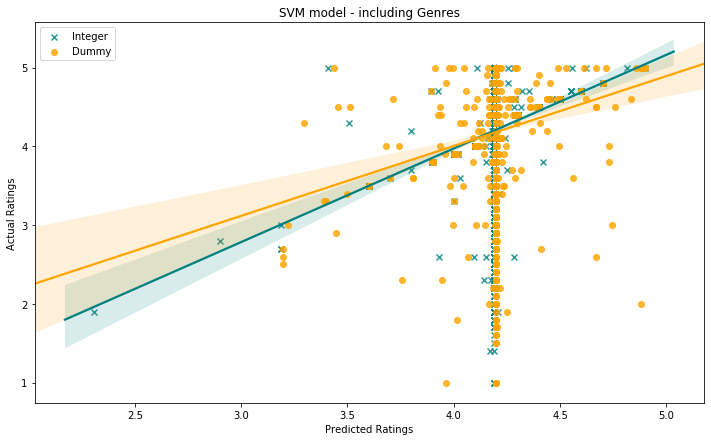

In [36]:
plt.figure(figsize=(12,7))
sns.regplot(Results2a,y_test,color='teal', label = 'Integer', marker = 'x')
sns.regplot(Results2a_d,y_test_d,color='orange',label = 'Dummy')
plt.legend()
plt.title('SVM model - including Genres')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

In [37]:
print ('Integer encoding(mean) :' + str(Results2a.mean()))
print ('Dummy encoding(mean) :'+ str(Results2a_d.mean()))
print ('Integer encoding(std) :' + str(Results2a.std()))
print ('Dummy encoding(std) :'+ str(Results2a_d.std()))

Integer encoding(mean) :4.190518652259231
Dummy encoding(mean) :4.199523264247121
Integer encoding(std) :0.08037095411368904
Dummy encoding(std) :0.09284763083146974


With the inclusion of the genre variable, the dummy encoding model now seems to be performing better, as we see the regression line comparing the actual vs the predicted results to be very similar to that of the integer encoded model.

Furthermore the std of the dummy encoded model has fallen significantly, and now has a higher mean compared to the integer encoded model.

**Next up is the random forest regressor model.** 
Honestly this is my favorite model as not only is it fast, it also allows you to see what independent variables significantly affect the outcome of the model.

In [38]:
from sklearn.ensemble import RandomForestRegressor

#Integer encoding
X = df.drop(labels = ['Category','Rating','Genres','Genres_c'],axis = 1)
y = df.Rating
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
model3 = RandomForestRegressor()
model3.fit(X_train,y_train)
Results3 = model3.predict(X_test)

#evaluation
resultsdf = resultsdf.append(Evaluationmatrix_dict(y_test,Results3, name = 'RFR - Integer'),ignore_index = True)

#dummy encoding

X_d = df2.drop(labels = ['Rating','Genres','Category_c','Genres_c'],axis = 1)
y_d = df2.Rating
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d, test_size=0.30)
model3_d = RandomForestRegressor()
model3_d.fit(X_train_d,y_train_d)
Results3_d = model3_d.predict(X_test_d)

#evaluation
resultsdf = resultsdf.append(Evaluationmatrix_dict(y_test,Results3_d, name = 'RFR - Dummy'),ignore_index = True)

C:\Users\ruji-\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ruji-\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


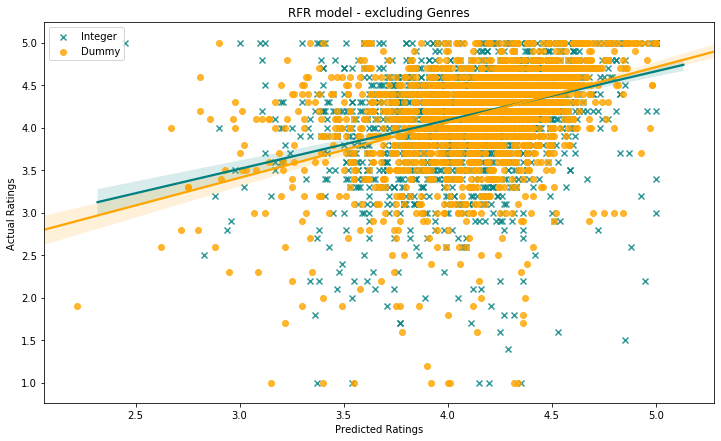

In [39]:
plt.figure(figsize=(12,7))
sns.regplot(Results3,y_test,color='teal', label = 'Integer', marker = 'x')
sns.regplot(Results3_d,y_test_d,color='orange',label = 'Dummy')
plt.legend()
plt.title('RFR model - excluding Genres')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

In [40]:
print ('Integer encoding(mean) :' + str(Results3.mean()))
print ('Dummy encoding(mean) :'+ str(Results3_d.mean()))
print ('Integer encoding(std) :' + str(Results3.std()))
print ('Dummy encoding(std) :'+ str(Results3_d.std()))

Integer encoding(mean) :4.180377849002849
Dummy encoding(mean) :4.185259377967711
Integer encoding(std) :0.3115151444498069
Dummy encoding(std) :0.3246826149369332


At first glance, I would say that the RFR model produced the best predictive results, just looking at the scatter graph plotted. Overall both models, the integer and the dummy encoded models seem to perform relatively similar, although the dummy encoded model has a higher overall predicted mean.

<Figure size 1008x720 with 0 Axes>

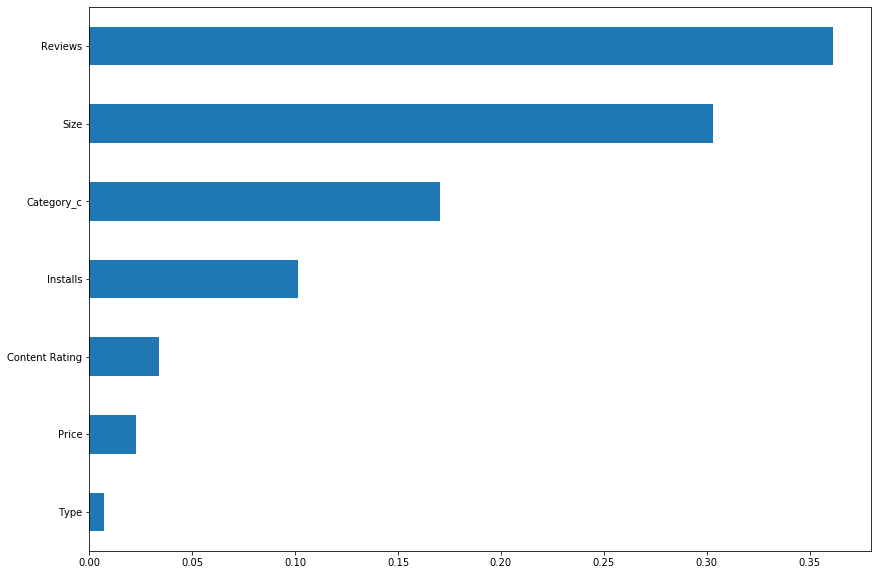

In [41]:
#for integer
Feat_impt = {}
for col,feat in zip(X.columns,model3.feature_importances_):
    Feat_impt[col] = feat

Feat_impt_df = pd.DataFrame.from_dict(Feat_impt,orient = 'index')
Feat_impt_df.sort_values(by = 0, inplace = True)
Feat_impt_df.rename(index = str, columns = {0:'Pct'},inplace = True)

plt.figure(figsize= (14,10))
Feat_impt_df.plot(kind = 'barh',figsize= (14,10),legend = False)
plt.show()

If we look at what influences the ratings, the top 4 being reviews, size, category, and number of installs seem to have the highest influence. This is quite an interesting observation, while also rationalizable.

<Figure size 1008x720 with 0 Axes>

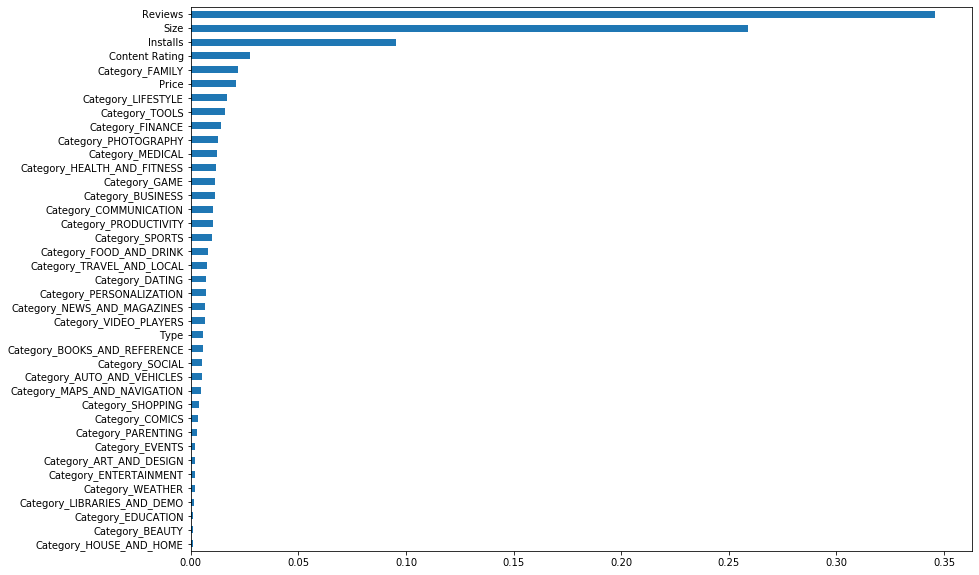

In [42]:
#for dummy
Feat_impt_d = {}
for col,feat in zip(X_d.columns,model3_d.feature_importances_):
    Feat_impt_d[col] = feat

Feat_impt_df_d = pd.DataFrame.from_dict(Feat_impt_d,orient = 'index')
Feat_impt_df_d.sort_values(by = 0, inplace = True)
Feat_impt_df_d.rename(index = str, columns = {0:'Pct'},inplace = True)

plt.figure(figsize= (14,10))
Feat_impt_df_d.plot(kind = 'barh',figsize= (14,10),legend = False)
plt.show()

Looking at the breakdown even further, it would seem that indeed Reviews, size and number of install remain as a significant contributer to the predictiveness of app ratings.  What's interesting to me is that how the Tools category of apps have such a high level of predictiveness in terms of ratings, as say compared to the Food and Drink category.

In [43]:

#Including Genres_C

#Integer encoding
X = df.drop(labels = ['Category','Rating','Genres'],axis = 1)
y = df.Rating
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
model3a = RandomForestRegressor()
model3a.fit(X_train,y_train)
Results3a = model3a.predict(X_test)

#evaluation
resultsdf = resultsdf.append(Evaluationmatrix_dict(y_test,Results3a, name = 'RFR(inc Genres) - Integer'),ignore_index = True)

#dummy encoding

X_d = df2.drop(labels = ['Rating','Genres','Category_c'],axis = 1)
y_d = df2.Rating
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d, test_size=0.30)
model3a_d = RandomForestRegressor()
model3a_d.fit(X_train_d,y_train_d)
Results3a_d = model3a_d.predict(X_test_d)

#evaluation
resultsdf = resultsdf.append(Evaluationmatrix_dict(y_test,Results3a_d, name = 'RFR(inc Genres) - Dummy'),ignore_index = True)

C:\Users\ruji-\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ruji-\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


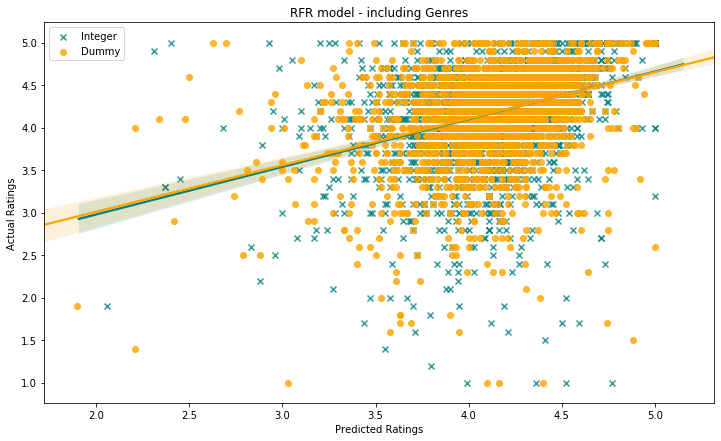

In [44]:
plt.figure(figsize=(12,7))
sns.regplot(Results3a,y_test,color='teal', label = 'Integer', marker = 'x')
sns.regplot(Results3a_d,y_test_d,color='orange',label = 'Dummy')
plt.legend()
plt.title('RFR model - including Genres')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

In [45]:
print ('Integer encoding(mean) :' + str(Results3.mean()))
print ('Dummy encoding(mean) :'+ str(Results3_d.mean()))
print ('Integer encoding(std) :' + str(Results3.std()))
print ('Dummy encoding(std) :'+ str(Results3_d.std()))

Integer encoding(mean) :4.180377849002849
Dummy encoding(mean) :4.185259377967711
Integer encoding(std) :0.3115151444498069
Dummy encoding(std) :0.3246826149369332


Again with the inclusion of the genre variable, the results do not seem to defer significantly as compared to the previous results.

<Figure size 1008x720 with 0 Axes>

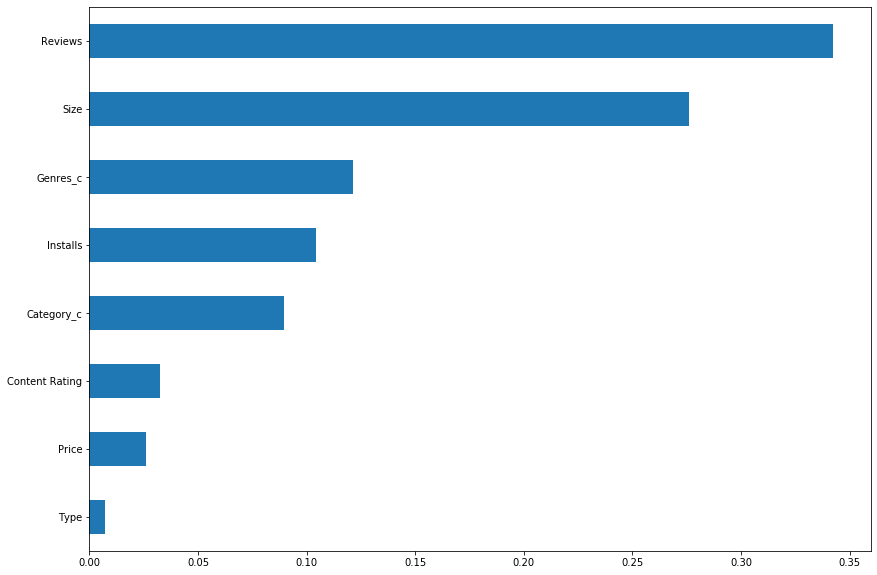

In [46]:
#for integer
Feat_impt = {}
for col,feat in zip(X.columns,model3a.feature_importances_):
    Feat_impt[col] = feat

Feat_impt_df = pd.DataFrame.from_dict(Feat_impt,orient = 'index')
Feat_impt_df.sort_values(by = 0, inplace = True)
Feat_impt_df.rename(index = str, columns = {0:'Pct'},inplace = True)

plt.figure(figsize= (14,10))
Feat_impt_df.plot(kind = 'barh',figsize= (14,10),legend = False)
plt.show()

From the results, it would seem that the genre section actually plays an important part in the decision tree making. Yet the exclusion of it dosent seem to significantly impact results. This to me is quite interesting.

<Figure size 1008x720 with 0 Axes>

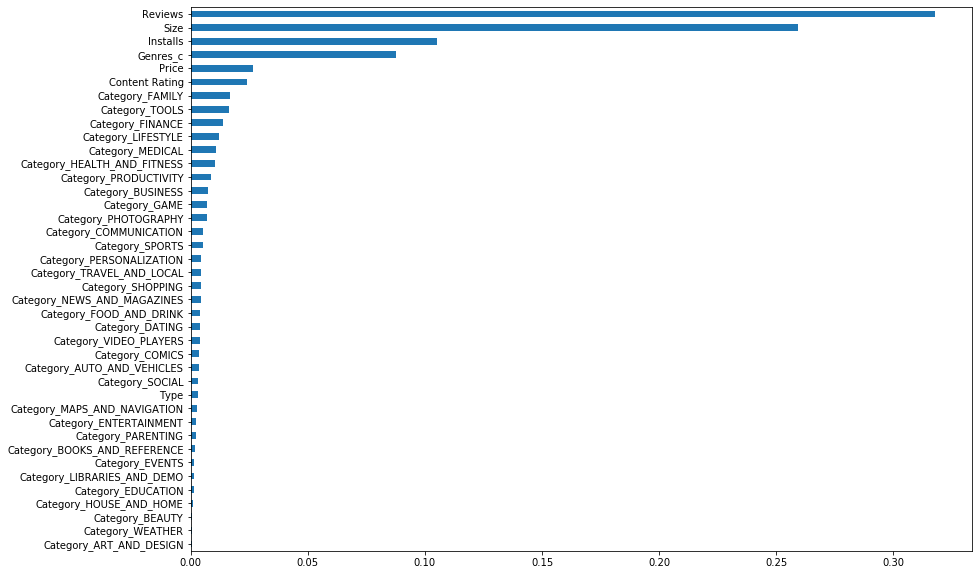

In [47]:
#for dummy
Feat_impt_d = {}
for col,feat in zip(X_d.columns,model3a_d.feature_importances_):
    Feat_impt_d[col] = feat

Feat_impt_df_d = pd.DataFrame.from_dict(Feat_impt_d,orient = 'index')
Feat_impt_df_d.sort_values(by = 0, inplace = True)
Feat_impt_df_d.rename(index = str, columns = {0:'Pct'},inplace = True)

plt.figure(figsize= (14,10))
Feat_impt_df_d.plot(kind = 'barh',figsize= (14,10),legend = False)
plt.show()

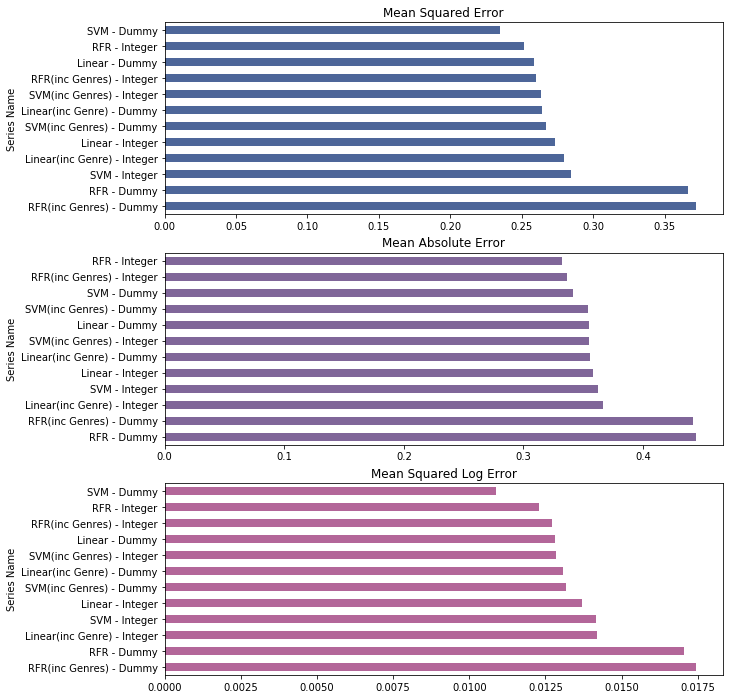

In [48]:
resultsdf.set_index('Series Name', inplace = True)

plt.figure(figsize = (10,12))
plt.subplot(3,1,1)
resultsdf['Mean Squared Error'].sort_values(ascending = False).plot(kind = 'barh',color=(0.3, 0.4, 0.6, 1), title = 'Mean Squared Error')
plt.subplot(3,1,2)
resultsdf['Mean Absolute Error'].sort_values(ascending = False).plot(kind = 'barh',color=(0.5, 0.4, 0.6, 1), title = 'Mean Absolute Error')
plt.subplot(3,1,3)
resultsdf['Mean Squared Log Error'].sort_values(ascending = False).plot(kind = 'barh',color=(0.7, 0.4, 0.6, 1), title = 'Mean Squared Log Error')
plt.show()


Finally, looking at the results, it is not easy to conclude which model has the best predictive accuracy and lowest error term. Using this round of data as a basis, the dummy encoded SVM model including genres has the lowest overall error rates, followed by the integer encoded RFR model including genes. Yet, all models seem to be very close in terms of it's error term, so this result is likely to change.

What is very surprising to me is how the RFR dummy model has such a significantly more error term compared to all the other models, even though on the surface it seemed to perform very similarly to the RFR integer model.

**Concluding thoughts**
It was pretty fun doing this project, using the three different machine learning models for continuous variables to see if it performed well in predictive analysis, based on the data that was provided.  If you guys have any suggestions/comments please do feel free to post, as I'm still a beginner and want to learn more! Have a great and blessed day everyone!